In [76]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
import zipfile
import imageio
import random
sns.set_context('notebook')
import glob
import cv2
import skimage
import skimage.transform
import keras
from keras.layers.normalization import BatchNormalization
print('Keras', keras.__version__)
from keras import backend as K
print('GPU:', K.tensorflow_backend._get_available_gpus())

Keras 2.2.4
GPU: ['/job:localhost/replica:0/task:0/device:GPU:0']


In [0]:
users = np.array(["user_3", "user_4", "user_5", "user_6", "user_7", "user_9", "user_10"])
letters = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'])

number_of_classes = len(letters)

In [0]:
# Download and unzip data

url = 'https://github.com/yoavram/Sign-Language/raw/master/Dataset.zip'
filename = '../data/sign-lang/Dataset.zip'
if not os.path.exists('../data'):
    os.mkdir('../data')
if not os.path.exists('../data/sign-lang'):
    os.mkdir('../data/sign-lang')
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)
    
zfile = zipfile.ZipFile(filename)
zfile.extractall("../data/sign-lang/Dataset")

In [0]:
# Collect images (not cropped) to an array

images = []
for user in users:
  images.append([imageio.imread(file) for file in sorted(glob.glob('../data/sign-lang/Dataset/Dataset/{}/*.jpg'.format(user)))])
images = np.array(images)

width = 128
height = 128    # 128 X 128 is the chosen width and height respectively for resize
num_of_pixels = 3

In [0]:
# Collect all data from .csv files to an array

csv_data = []
for user in users:
  user_data = np.genfromtxt('../data/sign-lang/Dataset/Dataset/{0}/{0}'.format(user) + '_loc.csv', delimiter=',')
  csv_data.append(user_data[1:, 1:5])   # Takes only numerical data
csv_data = np.array(csv_data).astype(int) 

In [0]:
# Image processing - defined function that crops a unique image, than use it to crop all given images 

def preprocess(image, box):
  top_left_x, top_left_y, bottom_right_x, bottom_right_y = box
  cropped = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x, :]
  cropped = skimage.transform.resize(cropped, (128,128,3), mode='constant')
  
  return cropped


def crop_images(images_arr, users_arr):  
  number_of_users = len(users_arr)
  images_per_user = len(images_arr[0])   # assume each user took the same amount of images
  total_images = number_of_users * images_per_user
  
  cropped_images = np.empty((number_of_users, images_per_user, width, height, num_of_pixels))  

  for i in range(total_images):
    user = i // images_per_user
    image_num = i % images_per_user
    im = images[user, image_num]
    
    cropped = preprocess(im, csv_data[user, image_num])
    cropped_images[user, image_num] = cropped

  return cropped_images

In [0]:
# Use one-hot encoding for splitting data to test and train

def encode(images_arr, user_arr):
  one_hot_arr = np.zeros((len(user_arr), len(images_arr[0]), number_of_classes))
  for letter in range(number_of_classes):
    one_hot_arr[:, (10*letter) : (10*letter + 10), letter] = 1
    
  return one_hot_arr

  
cropped = crop_images(images, users)
  
x_train = cropped[:6]
x_train = x_train.reshape((-1, width, height, num_of_pixels))
x_test = cropped[6:7]
x_test = x_test.reshape((-1, width, height, num_of_pixels))

y_train = encode(images, users[:6])
y_train = y_train.reshape((-1, number_of_classes))
y_test = encode(images, users[6:7])
y_test = y_test.reshape((-1, number_of_classes))

In [124]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(16, (5, 5), input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(32, (5, 5)))
model.add(BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(64, (5, 5)))
model.add(BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(128, (5, 5)))
model.add(BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(BatchNormalization())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024))
model.add(BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(24))
model.add(keras.layers.Activation('softmax'))


opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=20, epochs=10,
    validation_data=(x_test, y_test)
).history

Train on 1440 samples, validate on 240 samples
Epoch 1/10
1440/1440 [==============================] - 8s 6ms/step - loss: 1.5021 - acc: 0.5861 - val_loss: 0.9736 - val_acc: 0.7292
Epoch 2/10
1440/1440 [==============================] - 3s 2ms/step - loss: 0.3623 - acc: 0.9431 - val_loss: 0.6895 - val_acc: 0.7917
Epoch 3/10
1440/1440 [==============================] - 3s 2ms/step - loss: 0.1188 - acc: 0.9917 - val_loss: 0.6357 - val_acc: 0.8042
Epoch 4/10
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0452 - acc: 0.9972 - val_loss: 0.4728 - val_acc: 0.8542
Epoch 5/10
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0207 - acc: 1.0000 - val_loss: 0.5086 - val_acc: 0.8125
Epoch 6/10
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.5101 - val_acc: 0.8125
Epoch 7/10
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.4785 - val_acc: 0.8292
Epoch 8/10
1440

In [125]:
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

240/240 [==============================] - 0s 904us/step
Test loss: 0.46189886865516505
Test accuracy: 0.85


In [0]:
def synchronized_shuffle(images_arr, predicted_classes):   # Suffle images but keeps classes array synchronized with the images after the shuffle
  ziped = list(zip(images_arr, predicted_classes))
  np.random.shuffle(ziped)
  images_arr[:], predicted_classes[:] = zip(*ziped)
  
  return images_arr, predicted_classes


def decode(predicted_classes):
  data = letters[predicted_classes.argmax()]
    
  return data

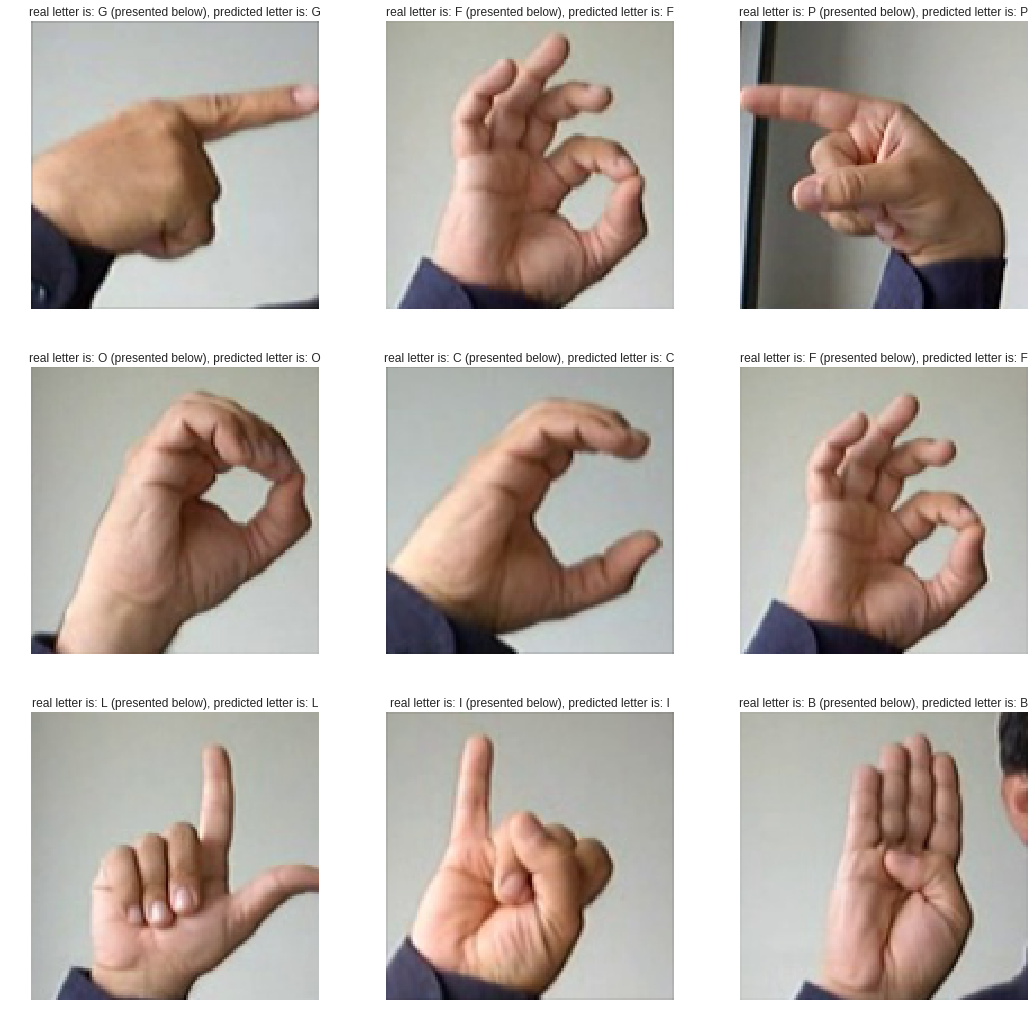

In [128]:
def compare(images_arr, predicted_classes):
  images_copy = np.copy(images_arr)
  predicted_copy = np.copy(predicted_classes)
  
  shuffled_images, shuffled_classes = synchronized_shuffle(images_copy, predicted_copy)
  random_images = shuffled_images[:9]
  random_classes = shuffled_classes[:9]
  
  prediction = model.predict(random_images).argmax(axis=1)
  
  plt.figure(figsize=(18, 18))
  for i in range(len(random_images)):
    plt.subplot(3, 3, i+1) 
    plt.title("real letter is: {} (presented below), predicted letter is: {}".format(decode(random_classes[i]), letters[prediction[i]])) 
    plt.imshow(random_images[i])
    plt.axis('off')

  plt.show()


compare(x_test, y_test)

mis-classified classes: ['D' 'M' 'N' 'R' 'S']


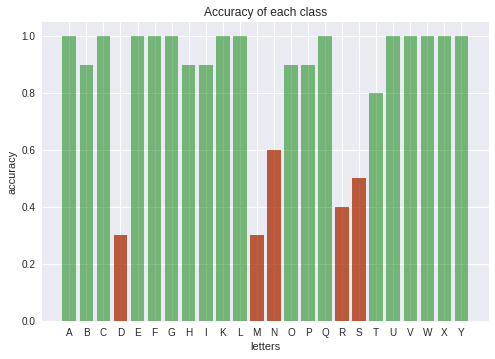

In [129]:
def accuracy(images_arr, predicted_classes):
  number_of_images = len(images_arr)
  model_prediction = model.predict(images_arr).argmax(axis=1)

  counters = np.zeros(number_of_classes) 
  for i in range(number_of_images):
    letter_prediction = letters[model_prediction[i]]
    real_value = decode(predicted_classes[i])
    if (letter_prediction == real_value):
      counters[(i // (number_of_images // (number_of_classes))) % number_of_classes] += 1
                     
  probs = counters / (number_of_images // number_of_classes)
  mis_classified = letters[probs < 0.7]   # assume bad prediction is under 70% successful identification percentage
  
  return probs, mis_classified 
  
  
acc, mis = accuracy(x_test, y_test)
    
print('mis-classified classes: {}'.format(mis))
plt.bar(letters, acc, alpha=0.5, color='g')
plt.bar(mis, acc[acc < 0.7], alpha=0.5, color='r')
plt.xlabel('letters')
plt.ylabel('accuracy')
plt.title('Accuracy of each class')
plt.show()


